In [6]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model, model_from_json  # type: ignore
from tensorflow.keras.layers import (  # type: ignore
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.applications import MobileNetV3Large  # type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Изменение текущей рабочей директории
os.chdir("../")
%pwd

'/Users/andrejizvarin/Documents/___project/emotion_recognition'

In [3]:
from src.data_loader import DataLoader

data_path = "data"
data_loader = DataLoader(data_path)
train_df, val_df = train_test_split(
    data_loader.labels_df, test_size=0.2, random_state=42
)

In [4]:
# Функция для подсчета всех файлов в директории и всех ее поддиректориях
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))


# Функция для аугментации изображений
def augment_images(image, label):
    # Применение случайного отражения по горизонтали
    image = tf.image.random_flip_left_right(image)
    # Применение случайного изменения яркости
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Применение случайного изменения контраста
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Применение случайного изменения насыщенности
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    # Применение случайного изменения оттенка
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label


# Функция для подготовки и предобработки данных
def prepare_dataset(dataset_type="train", batch_size=32):
    # Генерация данных из функции load_dataset с batch_size
    dataset = tf.data.Dataset.from_generator(
        lambda: data_loader.load_dataset(
            dataset_type=dataset_type, batch_size=batch_size
        ),
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
        ),
    )
    # Вычисление общего количества изображений по категориям
    total_images = count_files_in_directory(os.path.join(data_path, "train"))
    # Установка размера буфера перемешивания на 20% от общего количества изображений
    buffer_size = int(total_images * 0.2)
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Применение аугментации к изображениям
    dataset = dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    # Нормализация изображений после аугментации
    dataset = dataset.map(
        lambda x, y: (tf.image.per_image_standardization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    # Предварительная загрузка данных для ускорения обучения
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Повторение данных для обеспечения непрерывной подачи в модель
    dataset = dataset.repeat()

    return dataset


# Создание обучающего и валидационного наборов данных
train_dataset = prepare_dataset(dataset_type="train", batch_size=32)
val_dataset = prepare_dataset(dataset_type="val", batch_size=32)

In [5]:
def create_mobilenetv3_model(num_classes=9, fine_tune=False):
    base_model = MobileNetV3Large(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    if fine_tune:
        # Разморозка всех слоев
        for layer in base_model.layers[-30:]:
            layer.trainable = True
    else:
        # Заморозка базовой модели
        base_model.trainable = False

    # Добавление новых слоев
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)  # Слой Dropout для предотвращения переобучения
    outputs = Dense(num_classes, activation="softmax")(x)

    # Собираем полную модель
    model = Model(inputs=base_model.input, outputs=outputs)

    # Компилируем модель
    model.compile(
        optimizer=Adam(learning_rate=0.0001 if fine_tune else 0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = create_mobilenetv3_model(num_classes=9, fine_tune=True)

In [6]:
# Обучение модели
history = model.fit(
    train_dataset,
    epochs=16,
    steps_per_epoch=len(data_loader.train_df) // 32,
    validation_data=val_dataset,
    validation_steps=len(data_loader.val_df) // 32,
)

Epoch 1/16


2024-05-03 06:09:25.656662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 66 of 10009
2024-05-03 06:09:45.642969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 200 of 10009
2024-05-03 06:09:55.807811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 263 of 10009
2024-05-03 06:10:15.596844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 390 of 10009
2024-05-03 06:10:25.721724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 453 of 10009
2024-05-03 06:10:45.618507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.2499 - loss: 2.2809

2024-05-03 06:29:31.336179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 66 of 10009
2024-05-03 06:29:41.378791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 135 of 10009
2024-05-03 06:29:51.413310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 203 of 10009
2024-05-03 06:30:07.644199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1311s 886ms/step - accuracy: 0.2500 - loss: 2.2807 - val_accuracy: 0.2443 - val_loss: 2.1179
Epoch 2/16
   1/1251 ━━━━━━━━━━━━━━━━━━━━ 17:00 816ms/step - accuracy: 0.5938 - loss: 1.1626

2024-05-03 06:31:06.556601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 65 of 10009
2024-05-03 06:31:26.566964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 201 of 10009
2024-05-03 06:31:46.588445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 334 of 10009
2024-05-03 06:32:06.573475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 465 of 10009
2024-05-03 06:32:26.654047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 603 of 10009
2024-05-03 06:32:46.638675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.4434 - loss: 1.5766

2024-05-03 06:50:52.654256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 67 of 10009
2024-05-03 06:51:02.742492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 139 of 10009
2024-05-03 06:51:12.742966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 209 of 10009
2024-05-03 06:51:27.695644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1279s 1s/step - accuracy: 0.4434 - loss: 1.5766 - val_accuracy: 0.3023 - val_loss: 1.9406
Epoch 3/16
   2/1251 ━━━━━━━━━━━━━━━━━━━━ 15:26 742ms/step - accuracy: 0.5234 - loss: 1.2288

2024-05-03 06:52:25.233072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 66 of 10009
2024-05-03 06:52:45.247813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 206 of 10009
2024-05-03 06:52:55.259735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 273 of 10009
2024-05-03 06:53:05.286044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 341 of 10009
2024-05-03 06:53:15.335720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 411 of 10009
2024-05-03 06:53:35.323008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.5149 - loss: 1.3439

2024-05-03 07:11:58.082656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 64 of 10009
2024-05-03 07:12:08.137939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 135 of 10009
2024-05-03 07:12:18.828691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 206 of 10009
2024-05-03 07:12:28.922946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 272 of 10009
2024-05-03 07:12:35.292461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 07:12:48.139719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 382 of 10009
2024-05-03 07:13:08.188314: I tensorflow/c

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1266s 1s/step - accuracy: 0.5149 - loss: 1.3439 - val_accuracy: 0.3774 - val_loss: 1.7504
Epoch 4/16
   3/1251 ━━━━━━━━━━━━━━━━━━━━ 23:11 1s/step - accuracy: 0.4809 - loss: 1.4317

2024-05-03 07:13:28.046025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 608 of 10009
2024-05-03 07:13:38.175023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 671 of 10009
2024-05-03 07:13:48.214809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 739 of 10009
2024-05-03 07:14:00.957112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 258 of 10009
2024-05-03 07:14:09.269462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 07:14:18.075566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 937 of 10009
2024-05-03 07:14:28.197121: I tensorflow/

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.5715 - loss: 1.1850

2024-05-03 07:31:36.361449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 53 of 10009
2024-05-03 07:31:46.387963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 113 of 10009
2024-05-03 07:32:06.315219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 223 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1136s 908ms/step - accuracy: 0.5715 - loss: 1.1850 - val_accuracy: 0.4511 - val_loss: 1.5534
Epoch 5/16
   4/1251 ━━━━━━━━━━━━━━━━━━━━ 16:30 794ms/step - accuracy: 0.5195 - loss: 1.2123

2024-05-03 07:32:26.331716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 338 of 10009
2024-05-03 07:32:46.243748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 476 of 10009
2024-05-03 07:32:56.319434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 545 of 10009
2024-05-03 07:33:16.371166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 680 of 10009
2024-05-03 07:33:26.404093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 748 of 10009
2024-05-03 07:33:46.283341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a w

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.6334 - loss: 1.0206

2024-05-03 07:51:18.516863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 51 of 10009
2024-05-03 07:51:28.566976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 121 of 10009
2024-05-03 07:51:47.096488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 198 of 10009
2024-05-03 07:51:57.106302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 262 of 10009
2024-05-03 07:52:04.776113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 07:52:08.471438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 369 of 10009
2024-05-03 07:52:18.664471: I tensorflow/c

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1235s 987ms/step - accuracy: 0.6334 - loss: 1.0206 - val_accuracy: 0.4571 - val_loss: 1.6385
Epoch 6/16
   5/1251 ━━━━━━━━━━━━━━━━━━━━ 24:29 1s/step - accuracy: 0.6313 - loss: 1.0271

2024-05-03 07:52:58.457864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 643 of 10009
2024-05-03 07:53:11.631306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 117 of 10009
2024-05-03 07:53:21.676897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 182 of 10009
2024-05-03 07:53:31.694695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 248 of 10009
2024-05-03 07:53:41.666542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 07:53:48.415313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 972 of 10009
2024-05-03 07:53:58.537873: I tensorflow/

1238/1251 ━━━━━━━━━━━━━━━━━━━━ 11s 874ms/step - accuracy: 0.6959 - loss: 0.8471

2024-05-03 08:10:54.451726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 50 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.6959 - loss: 0.8473

2024-05-03 08:11:04.467958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 104 of 10009
2024-05-03 08:11:24.501516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 212 of 10009
2024-05-03 08:11:34.592367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 263 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1142s 912ms/step - accuracy: 0.6958 - loss: 0.8473 - val_accuracy: 0.4701 - val_loss: 1.6324
Epoch 7/16


2024-05-03 08:11:54.458084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 375 of 10009


   6/1251 ━━━━━━━━━━━━━━━━━━━━ 18:10 876ms/step - accuracy: 0.7438 - loss: 0.8721

2024-05-03 08:12:04.541337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 429 of 10009
2024-05-03 08:12:24.036625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 183 of 10009
2024-05-03 08:12:34.105281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 249 of 10009
2024-05-03 08:12:44.059086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 08:12:44.374642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 685 of 10009
2024-05-03 08:13:04.436860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 817 of 10009
2024-05-03 08:13:14.475405: I tensorflow/

1207/1251 ━━━━━━━━━━━━━━━━━━━━ 39s 896ms/step - accuracy: 0.7649 - loss: 0.6660

2024-05-03 08:29:56.862175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 51 of 10009


1233/1251 ━━━━━━━━━━━━━━━━━━━━ 16s 894ms/step - accuracy: 0.7647 - loss: 0.6664

2024-05-03 08:30:16.778807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 156 of 10009


1246/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 892ms/step - accuracy: 0.7646 - loss: 0.6666

2024-05-03 08:30:26.803901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 207 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7646 - loss: 0.6667

2024-05-03 08:30:46.828530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 316 of 10009
2024-05-03 08:30:56.909444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 371 of 10009
2024-05-03 08:31:16.795476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 483 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1164s 931ms/step - accuracy: 0.7646 - loss: 0.6667 - val_accuracy: 0.4737 - val_loss: 1.7779
Epoch 8/16
   7/1251 ━━━━━━━━━━━━━━━━━━━━ 22:49 1s/step - accuracy: 0.7380 - loss: 0.7713

2024-05-03 08:31:26.966980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 531 of 10009
2024-05-03 08:31:38.639521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 116 of 10009
2024-05-03 08:31:48.686265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 178 of 10009
2024-05-03 08:32:06.783803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 790 of 10009
2024-05-03 08:32:08.908959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 08:32:16.827556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 859 of 10009
2024-05-03 08:32:36.771785: I tensorflow/

1144/1251 ━━━━━━━━━━━━━━━━━━━━ 1:35 892ms/step - accuracy: 0.8255 - loss: 0.5004

2024-05-03 08:48:19.950334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 51 of 10009


1170/1251 ━━━━━━━━━━━━━━━━━━━━ 1:11 889ms/step - accuracy: 0.8253 - loss: 0.5008

2024-05-03 08:48:39.771723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 156 of 10009


1183/1251 ━━━━━━━━━━━━━━━━━━━━ 1:00 888ms/step - accuracy: 0.8252 - loss: 0.5009

2024-05-03 08:48:49.928996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 208 of 10009


1196/1251 ━━━━━━━━━━━━━━━━━━━━ 48s 886ms/step - accuracy: 0.8251 - loss: 0.5011

2024-05-03 08:49:00.050657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 258 of 10009


1222/1251 ━━━━━━━━━━━━━━━━━━━━ 25s 884ms/step - accuracy: 0.8249 - loss: 0.5015

2024-05-03 08:49:19.875204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 360 of 10009


1234/1251 ━━━━━━━━━━━━━━━━━━━━ 15s 883ms/step - accuracy: 0.8249 - loss: 0.5017

2024-05-03 08:49:29.934681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 411 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.8248 - loss: 0.5019

2024-05-03 08:49:49.861661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 516 of 10009
2024-05-03 08:49:59.874350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 572 of 10009
2024-05-03 08:50:19.822555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 679 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1151s 920ms/step - accuracy: 0.8248 - loss: 0.5019 - val_accuracy: 0.4643 - val_loss: 2.0927
Epoch 9/16


2024-05-03 08:50:29.847226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 736 of 10009


   8/1251 ━━━━━━━━━━━━━━━━━━━━ 17:16 834ms/step - accuracy: 0.8258 - loss: 0.5094

2024-05-03 08:50:39.859450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 786 of 10009
2024-05-03 08:50:49.863087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 855 of 10009
2024-05-03 08:51:09.767901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 991 of 10009
2024-05-03 08:51:19.815463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1061 of 10009
2024-05-03 08:51:29.819071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1130 of 10009
2024-05-03 08:51:39.940261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a

1017/1251 ━━━━━━━━━━━━━━━━━━━━ 3:22 866ms/step - accuracy: 0.8759 - loss: 0.3623

2024-05-03 09:05:11.365983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 51 of 10009


1043/1251 ━━━━━━━━━━━━━━━━━━━━ 2:59 863ms/step - accuracy: 0.8758 - loss: 0.3625

2024-05-03 09:05:31.275645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 156 of 10009


1068/1251 ━━━━━━━━━━━━━━━━━━━━ 2:37 862ms/step - accuracy: 0.8757 - loss: 0.3627

2024-05-03 09:05:51.425971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 256 of 10009


1093/1251 ━━━━━━━━━━━━━━━━━━━━ 2:15 860ms/step - accuracy: 0.8755 - loss: 0.3629

2024-05-03 09:06:11.293231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 354 of 10009


1105/1251 ━━━━━━━━━━━━━━━━━━━━ 2:05 860ms/step - accuracy: 0.8755 - loss: 0.3631

2024-05-03 09:06:21.386044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 404 of 10009


1129/1251 ━━━━━━━━━━━━━━━━━━━━ 1:44 860ms/step - accuracy: 0.8753 - loss: 0.3633

2024-05-03 09:06:41.275698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 500 of 10009


1141/1251 ━━━━━━━━━━━━━━━━━━━━ 1:34 860ms/step - accuracy: 0.8752 - loss: 0.3634

2024-05-03 09:06:51.330678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 550 of 10009


1152/1251 ━━━━━━━━━━━━━━━━━━━━ 1:25 860ms/step - accuracy: 0.8752 - loss: 0.3635

2024-05-03 09:07:01.369229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 601 of 10009


1176/1251 ━━━━━━━━━━━━━━━━━━━━ 1:04 859ms/step - accuracy: 0.8750 - loss: 0.3638

2024-05-03 09:07:21.239092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 697 of 10009


1200/1251 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 0.8749 - loss: 0.3641

2024-05-03 09:07:41.186948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 793 of 10009


1212/1251 ━━━━━━━━━━━━━━━━━━━━ 33s 858ms/step - accuracy: 0.8748 - loss: 0.3642

2024-05-03 09:07:51.316874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 844 of 10009


1237/1251 ━━━━━━━━━━━━━━━━━━━━ 12s 858ms/step - accuracy: 0.8746 - loss: 0.3645

2024-05-03 09:08:11.254378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 946 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8746 - loss: 0.3647

2024-05-03 09:08:31.224703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1060 of 10009
2024-05-03 09:08:42.917996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 132 of 10009
2024-05-03 09:08:59.554544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-03 09:09:02.818146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 260 of 10009
2024-05-03 09:09:11.278086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1165s 931ms/step - accuracy: 0.8745 - loss: 0.3647 - val_accuracy: 0.4328 - val_loss: 2.3473
Epoch 10/16
  12/1251 ━━━━━━━━━━━━━━━━━━━━ 15:54 771ms/step - accuracy: 0.8726 - loss: 0.3765

2024-05-03 09:10:03.673384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 53 of 10009


  36/1251 ━━━━━━━━━━━━━━━━━━━━ 16:21 808ms/step - accuracy: 0.8916 - loss: 0.3205

2024-05-03 09:10:23.732553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 153 of 10009


  48/1251 ━━━━━━━━━━━━━━━━━━━━ 16:16 812ms/step - accuracy: 0.8953 - loss: 0.3097

2024-05-03 09:10:33.832296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 204 of 10009


  72/1251 ━━━━━━━━━━━━━━━━━━━━ 16:01 816ms/step - accuracy: 0.8990 - loss: 0.2981

2024-05-03 09:10:53.722165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 302 of 10009


  75/1251 ━━━━━━━━━━━━━━━━━━━━ 16:00 817ms/step - accuracy: 0.8993 - loss: 0.2972

2024-05-03 09:10:55.944089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1016/1251 ━━━━━━━━━━━━━━━━━━━━ 3:10 809ms/step - accuracy: 0.9148 - loss: 0.2567

2024-05-03 09:23:36.772213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 46 of 10009


1029/1251 ━━━━━━━━━━━━━━━━━━━━ 2:59 809ms/step - accuracy: 0.9148 - loss: 0.2568

2024-05-03 09:23:46.938398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 100 of 10009


1053/1251 ━━━━━━━━━━━━━━━━━━━━ 2:40 809ms/step - accuracy: 0.9146 - loss: 0.2570

2024-05-03 09:24:06.890909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 198 of 10009


1065/1251 ━━━━━━━━━━━━━━━━━━━━ 2:30 809ms/step - accuracy: 0.9146 - loss: 0.2571

2024-05-03 09:24:16.917016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 248 of 10009


1090/1251 ━━━━━━━━━━━━━━━━━━━━ 2:10 809ms/step - accuracy: 0.9145 - loss: 0.2574

2024-05-03 09:24:36.791856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 344 of 10009


1102/1251 ━━━━━━━━━━━━━━━━━━━━ 2:00 809ms/step - accuracy: 0.9144 - loss: 0.2575

2024-05-03 09:24:46.847636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 395 of 10009


1115/1251 ━━━━━━━━━━━━━━━━━━━━ 1:50 809ms/step - accuracy: 0.9144 - loss: 0.2576

2024-05-03 09:24:56.857842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 444 of 10009


1127/1251 ━━━━━━━━━━━━━━━━━━━━ 1:40 810ms/step - accuracy: 0.9143 - loss: 0.2578

2024-05-03 09:25:06.917572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 497 of 10009


1151/1251 ━━━━━━━━━━━━━━━━━━━━ 1:20 809ms/step - accuracy: 0.9142 - loss: 0.2580

2024-05-03 09:25:26.817374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 600 of 10009


1176/1251 ━━━━━━━━━━━━━━━━━━━━ 1:00 810ms/step - accuracy: 0.9140 - loss: 0.2583

2024-05-03 09:25:46.781958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 699 of 10009


1188/1251 ━━━━━━━━━━━━━━━━━━━━ 51s 810ms/step - accuracy: 0.9140 - loss: 0.2584

2024-05-03 09:25:56.865545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 748 of 10009


1200/1251 ━━━━━━━━━━━━━━━━━━━━ 41s 810ms/step - accuracy: 0.9139 - loss: 0.2585

2024-05-03 09:26:06.884410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 798 of 10009


1224/1251 ━━━━━━━━━━━━━━━━━━━━ 21s 810ms/step - accuracy: 0.9138 - loss: 0.2588

2024-05-03 09:26:26.855918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 902 of 10009


1237/1251 ━━━━━━━━━━━━━━━━━━━━ 11s 810ms/step - accuracy: 0.9137 - loss: 0.2590

2024-05-03 09:26:36.905580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 951 of 10009


1249/1251 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - accuracy: 0.9136 - loss: 0.2591

2024-05-03 09:26:46.938659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1003 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9136 - loss: 0.2591

2024-05-03 09:26:56.948814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1059 of 10009
2024-05-03 09:27:16.865924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1171 of 10009
2024-05-03 09:27:26.907737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1227 of 10009
2024-05-03 09:27:31.674880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1063s 850ms/step - accuracy: 0.9136 - loss: 0.2592 - val_accuracy: 0.4368 - val_loss: 2.7887
Epoch 11/16
  10/1251 ━━━━━━━━━━━━━━━━━━━━ 17:10 831ms/step - accuracy: 0.8715 - loss: 0.3521

2024-05-03 09:27:47.135097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 47 of 10009


  34/1251 ━━━━━━━━━━━━━━━━━━━━ 16:49 829ms/step - accuracy: 0.8908 - loss: 0.2970

2024-05-03 09:28:07.079190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 146 of 10009


  46/1251 ━━━━━━━━━━━━━━━━━━━━ 16:49 838ms/step - accuracy: 0.8972 - loss: 0.2819

2024-05-03 09:28:17.097107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 192 of 10009


  58/1251 ━━━━━━━━━━━━━━━━━━━━ 16:42 841ms/step - accuracy: 0.9025 - loss: 0.2700

2024-05-03 09:28:27.139129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 240 of 10009


  70/1251 ━━━━━━━━━━━━━━━━━━━━ 16:28 837ms/step - accuracy: 0.9060 - loss: 0.2625

2024-05-03 09:28:37.182168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 291 of 10009


  75/1251 ━━━━━━━━━━━━━━━━━━━━ 16:26 838ms/step - accuracy: 0.9071 - loss: 0.2600

2024-05-03 09:28:41.909074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1018/1251 ━━━━━━━━━━━━━━━━━━━━ 3:08 807ms/step - accuracy: 0.9289 - loss: 0.2095

2024-05-03 09:41:20.695318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 49 of 10009


1030/1251 ━━━━━━━━━━━━━━━━━━━━ 2:58 808ms/step - accuracy: 0.9289 - loss: 0.2096

2024-05-03 09:41:30.718005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 103 of 10009


1043/1251 ━━━━━━━━━━━━━━━━━━━━ 2:47 808ms/step - accuracy: 0.9288 - loss: 0.2097

2024-05-03 09:41:40.770518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 152 of 10009


1067/1251 ━━━━━━━━━━━━━━━━━━━━ 2:28 808ms/step - accuracy: 0.9288 - loss: 0.2099

2024-05-03 09:42:00.687982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 252 of 10009


1080/1251 ━━━━━━━━━━━━━━━━━━━━ 2:18 808ms/step - accuracy: 0.9288 - loss: 0.2100

2024-05-03 09:42:10.718409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 303 of 10009


1092/1251 ━━━━━━━━━━━━━━━━━━━━ 2:08 808ms/step - accuracy: 0.9287 - loss: 0.2100

2024-05-03 09:42:20.804618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 352 of 10009


1104/1251 ━━━━━━━━━━━━━━━━━━━━ 1:58 808ms/step - accuracy: 0.9287 - loss: 0.2101

2024-05-03 09:42:30.834753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 403 of 10009


1128/1251 ━━━━━━━━━━━━━━━━━━━━ 1:39 808ms/step - accuracy: 0.9286 - loss: 0.2103

2024-05-03 09:42:50.708945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 505 of 10009


1153/1251 ━━━━━━━━━━━━━━━━━━━━ 1:19 808ms/step - accuracy: 0.9286 - loss: 0.2105

2024-05-03 09:43:10.853510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 612 of 10009


1177/1251 ━━━━━━━━━━━━━━━━━━━━ 59s 809ms/step - accuracy: 0.9285 - loss: 0.2106 

2024-05-03 09:43:30.744197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 712 of 10009


1190/1251 ━━━━━━━━━━━━━━━━━━━━ 49s 809ms/step - accuracy: 0.9285 - loss: 0.2107

2024-05-03 09:43:40.777993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 762 of 10009


1214/1251 ━━━━━━━━━━━━━━━━━━━━ 29s 809ms/step - accuracy: 0.9284 - loss: 0.2109

2024-05-03 09:44:00.868228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 866 of 10009


1239/1251 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step - accuracy: 0.9283 - loss: 0.2111 

2024-05-03 09:44:20.803333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 972 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9283 - loss: 0.2112

2024-05-03 09:44:40.702779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1078 of 10009
2024-05-03 09:44:50.732200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1133 of 10009
2024-05-03 09:45:00.776804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1193 of 10009
2024-05-03 09:45:11.729555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1062s 848ms/step - accuracy: 0.9283 - loss: 0.2112 - val_accuracy: 0.4221 - val_loss: 3.2375
Epoch 12/16
  10/1251 ━━━━━━━━━━━━━━━━━━━━ 16:54 818ms/step - accuracy: 0.8782 - loss: 0.3666

2024-05-03 09:45:29.277676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 48 of 10009


  22/1251 ━━━━━━━━━━━━━━━━━━━━ 17:15 842ms/step - accuracy: 0.8935 - loss: 0.3112

2024-05-03 09:45:39.377225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 99 of 10009


  46/1251 ━━━━━━━━━━━━━━━━━━━━ 16:42 832ms/step - accuracy: 0.9124 - loss: 0.2554

2024-05-03 09:45:59.276454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 198 of 10009


  59/1251 ━━━━━━━━━━━━━━━━━━━━ 16:25 827ms/step - accuracy: 0.9173 - loss: 0.2402

2024-05-03 09:46:09.354599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 250 of 10009


  71/1251 ━━━━━━━━━━━━━━━━━━━━ 16:16 828ms/step - accuracy: 0.9207 - loss: 0.2300

2024-05-03 09:46:19.449466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 299 of 10009


  74/1251 ━━━━━━━━━━━━━━━━━━━━ 16:13 827ms/step - accuracy: 0.9214 - loss: 0.2277

2024-05-03 09:46:22.286194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1020/1251 ━━━━━━━━━━━━━━━━━━━━ 3:07 813ms/step - accuracy: 0.9447 - loss: 0.1628

2024-05-03 09:59:09.548197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 50 of 10009


1032/1251 ━━━━━━━━━━━━━━━━━━━━ 2:57 813ms/step - accuracy: 0.9447 - loss: 0.1629

2024-05-03 09:59:19.646408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 104 of 10009


1057/1251 ━━━━━━━━━━━━━━━━━━━━ 2:37 812ms/step - accuracy: 0.9446 - loss: 0.1630

2024-05-03 09:59:39.634727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 202 of 10009


1082/1251 ━━━━━━━━━━━━━━━━━━━━ 2:17 812ms/step - accuracy: 0.9446 - loss: 0.1632

2024-05-03 09:59:59.551425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 302 of 10009


1106/1251 ━━━━━━━━━━━━━━━━━━━━ 1:57 812ms/step - accuracy: 0.9445 - loss: 0.1633

2024-05-03 10:00:19.647699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 401 of 10009


1119/1251 ━━━━━━━━━━━━━━━━━━━━ 1:47 812ms/step - accuracy: 0.9445 - loss: 0.1634

2024-05-03 10:00:29.746088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 451 of 10009


1144/1251 ━━━━━━━━━━━━━━━━━━━━ 1:26 812ms/step - accuracy: 0.9444 - loss: 0.1637

2024-05-03 10:00:49.490095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 554 of 10009


1156/1251 ━━━━━━━━━━━━━━━━━━━━ 1:17 812ms/step - accuracy: 0.9444 - loss: 0.1638

2024-05-03 10:00:59.591783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 608 of 10009


1169/1251 ━━━━━━━━━━━━━━━━━━━━ 1:06 811ms/step - accuracy: 0.9443 - loss: 0.1639

2024-05-03 10:01:09.625947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 656 of 10009


1194/1251 ━━━━━━━━━━━━━━━━━━━━ 46s 811ms/step - accuracy: 0.9443 - loss: 0.1641

2024-05-03 10:01:29.543488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 757 of 10009


1219/1251 ━━━━━━━━━━━━━━━━━━━━ 25s 811ms/step - accuracy: 0.9442 - loss: 0.1643

2024-05-03 10:01:49.713426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 859 of 10009


1244/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 811ms/step - accuracy: 0.9441 - loss: 0.1645

2024-05-03 10:02:09.505380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 961 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9441 - loss: 0.1646

2024-05-03 10:02:19.596398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1013 of 10009
2024-05-03 10:02:39.514395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1125 of 10009
2024-05-03 10:02:49.601111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1185 of 10009
2024-05-03 10:02:59.639179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1240 of 10009
2024-05-03 10:03:01.984726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1063s 849ms/step - accuracy: 0.9441 - loss: 0.1646 - val_accuracy: 0.4225 - val_loss: 3.2121
Epoch 13/16
   6/1251 ━━━━━━━━━━━━━━━━━━━━ 29:37 1s/step - accuracy: 0.9332 - loss: 0.2491

2024-05-03 10:03:11.635135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 32 of 10009


  18/1251 ━━━━━━━━━━━━━━━━━━━━ 20:38 1s/step - accuracy: 0.9329 - loss: 0.2341

2024-05-03 10:03:21.893976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 83 of 10009


  43/1251 ━━━━━━━━━━━━━━━━━━━━ 17:51 887ms/step - accuracy: 0.9427 - loss: 0.1936

2024-05-03 10:03:41.738128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 184 of 10009


  55/1251 ━━━━━━━━━━━━━━━━━━━━ 17:26 875ms/step - accuracy: 0.9452 - loss: 0.1822

2024-05-03 10:03:51.748769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 233 of 10009


  74/1251 ━━━━━━━━━━━━━━━━━━━━ 16:52 861ms/step - accuracy: 0.9476 - loss: 0.1711

2024-05-03 10:04:07.787087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1020/1251 ━━━━━━━━━━━━━━━━━━━━ 3:07 810ms/step - accuracy: 0.9558 - loss: 0.1356

2024-05-03 10:16:49.964159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 49 of 10009


1044/1251 ━━━━━━━━━━━━━━━━━━━━ 2:47 810ms/step - accuracy: 0.9557 - loss: 0.1357

2024-05-03 10:17:09.880992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 150 of 10009


1069/1251 ━━━━━━━━━━━━━━━━━━━━ 2:27 810ms/step - accuracy: 0.9556 - loss: 0.1359

2024-05-03 10:17:29.867042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 250 of 10009


1094/1251 ━━━━━━━━━━━━━━━━━━━━ 2:07 810ms/step - accuracy: 0.9556 - loss: 0.1361

2024-05-03 10:17:49.839733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 347 of 10009


1107/1251 ━━━━━━━━━━━━━━━━━━━━ 1:56 810ms/step - accuracy: 0.9555 - loss: 0.1362

2024-05-03 10:18:00.063987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 399 of 10009


1132/1251 ━━━━━━━━━━━━━━━━━━━━ 1:36 809ms/step - accuracy: 0.9554 - loss: 0.1364

2024-05-03 10:18:19.884274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 500 of 10009


1145/1251 ━━━━━━━━━━━━━━━━━━━━ 1:25 809ms/step - accuracy: 0.9554 - loss: 0.1366

2024-05-03 10:18:30.026511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 552 of 10009


1169/1251 ━━━━━━━━━━━━━━━━━━━━ 1:06 809ms/step - accuracy: 0.9553 - loss: 0.1368

2024-05-03 10:18:49.908810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 653 of 10009


1194/1251 ━━━━━━━━━━━━━━━━━━━━ 46s 809ms/step - accuracy: 0.9552 - loss: 0.1371

2024-05-03 10:19:10.010549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 754 of 10009


1219/1251 ━━━━━━━━━━━━━━━━━━━━ 25s 809ms/step - accuracy: 0.9551 - loss: 0.1373

2024-05-03 10:19:29.822606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 854 of 10009


1231/1251 ━━━━━━━━━━━━━━━━━━━━ 16s 809ms/step - accuracy: 0.9551 - loss: 0.1374

2024-05-03 10:19:39.909243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 908 of 10009


1244/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 809ms/step - accuracy: 0.9550 - loss: 0.1376

2024-05-03 10:19:49.911942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 958 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9550 - loss: 0.1376

2024-05-03 10:20:09.897647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1067 of 10009
2024-05-03 10:20:20.039605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1123 of 10009
2024-05-03 10:20:39.958242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1236 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1060s 846ms/step - accuracy: 0.9550 - loss: 0.1376 - val_accuracy: 0.4364 - val_loss: 3.3429
Epoch 14/16


2024-05-03 10:20:43.041736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


   6/1251 ━━━━━━━━━━━━━━━━━━━━ 32:11 2s/step - accuracy: 0.9649 - loss: 0.1417

2024-05-03 10:20:52.212242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 32 of 10009


  18/1251 ━━━━━━━━━━━━━━━━━━━━ 21:15 1s/step - accuracy: 0.9585 - loss: 0.1401

2024-05-03 10:21:02.409409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 83 of 10009


  42/1251 ━━━━━━━━━━━━━━━━━━━━ 18:20 910ms/step - accuracy: 0.9580 - loss: 0.1315

2024-05-03 10:21:22.150343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 184 of 10009


  55/1251 ━━━━━━━━━━━━━━━━━━━━ 17:42 888ms/step - accuracy: 0.9592 - loss: 0.1281

2024-05-03 10:21:32.200252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 234 of 10009


  67/1251 ━━━━━━━━━━━━━━━━━━━━ 17:18 877ms/step - accuracy: 0.9601 - loss: 0.1251

2024-05-03 10:21:42.317721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 285 of 10009


  74/1251 ━━━━━━━━━━━━━━━━━━━━ 17:08 874ms/step - accuracy: 0.9607 - loss: 0.1234

2024-05-03 10:21:47.958419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1021/1251 ━━━━━━━━━━━━━━━━━━━━ 3:08 818ms/step - accuracy: 0.9607 - loss: 0.1200

2024-05-03 10:34:39.706539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 50 of 10009


1046/1251 ━━━━━━━━━━━━━━━━━━━━ 2:47 818ms/step - accuracy: 0.9606 - loss: 0.1202

2024-05-03 10:34:59.759268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 153 of 10009


1071/1251 ━━━━━━━━━━━━━━━━━━━━ 2:27 818ms/step - accuracy: 0.9605 - loss: 0.1203

2024-05-03 10:35:19.652756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 252 of 10009


1084/1251 ━━━━━━━━━━━━━━━━━━━━ 2:16 818ms/step - accuracy: 0.9605 - loss: 0.1204

2024-05-03 10:35:29.829715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 303 of 10009


1108/1251 ━━━━━━━━━━━━━━━━━━━━ 1:56 817ms/step - accuracy: 0.9604 - loss: 0.1206

2024-05-03 10:35:49.623919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 401 of 10009


1121/1251 ━━━━━━━━━━━━━━━━━━━━ 1:46 817ms/step - accuracy: 0.9604 - loss: 0.1207

2024-05-03 10:35:59.913021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 451 of 10009


1146/1251 ━━━━━━━━━━━━━━━━━━━━ 1:25 817ms/step - accuracy: 0.9603 - loss: 0.1209

2024-05-03 10:36:19.855466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 552 of 10009


1170/1251 ━━━━━━━━━━━━━━━━━━━━ 1:06 817ms/step - accuracy: 0.9602 - loss: 0.1210

2024-05-03 10:36:39.714917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 651 of 10009


1195/1251 ━━━━━━━━━━━━━━━━━━━━ 45s 817ms/step - accuracy: 0.9601 - loss: 0.1212

2024-05-03 10:36:59.709023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 750 of 10009


1207/1251 ━━━━━━━━━━━━━━━━━━━━ 35s 817ms/step - accuracy: 0.9601 - loss: 0.1214

2024-05-03 10:37:09.741991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 799 of 10009


1232/1251 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.9600 - loss: 0.1216

2024-05-03 10:37:29.778948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 901 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.9599 - loss: 0.1217

2024-05-03 10:37:49.644370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1002 of 10009
2024-05-03 10:37:59.666601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1058 of 10009
2024-05-03 10:38:19.723490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1169 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1069s 854ms/step - accuracy: 0.9599 - loss: 0.1218 - val_accuracy: 0.4329 - val_loss: 3.6408
Epoch 15/16
   3/1251 ━━━━━━━━━━━━━━━━━━━━ 18:25 886ms/step - accuracy: 0.9531 - loss: 0.1253

2024-05-03 10:38:35.528695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


   7/1251 ━━━━━━━━━━━━━━━━━━━━ 29:03 1s/step - accuracy: 0.9412 - loss: 0.1560

2024-05-03 10:38:41.424891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 32 of 10009


  29/1251 ━━━━━━━━━━━━━━━━━━━━ 20:23 1s/step - accuracy: 0.9384 - loss: 0.1641

2024-05-03 10:39:01.336065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 127 of 10009


  41/1251 ━━━━━━━━━━━━━━━━━━━━ 19:10 951ms/step - accuracy: 0.9413 - loss: 0.1555

2024-05-03 10:39:11.373687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 175 of 10009


  53/1251 ━━━━━━━━━━━━━━━━━━━━ 18:24 922ms/step - accuracy: 0.9423 - loss: 0.1515

2024-05-03 10:39:21.392125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 225 of 10009


  65/1251 ━━━━━━━━━━━━━━━━━━━━ 17:53 906ms/step - accuracy: 0.9436 - loss: 0.1481

2024-05-03 10:39:31.486448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 274 of 10009


  75/1251 ━━━━━━━━━━━━━━━━━━━━ 17:30 894ms/step - accuracy: 0.9448 - loss: 0.1451

2024-05-03 10:39:39.242627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1023/1251 ━━━━━━━━━━━━━━━━━━━━ 3:06 817ms/step - accuracy: 0.9602 - loss: 0.1144

2024-05-03 10:52:28.141932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 50 of 10009


1035/1251 ━━━━━━━━━━━━━━━━━━━━ 2:56 817ms/step - accuracy: 0.9602 - loss: 0.1144

2024-05-03 10:52:38.160341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 104 of 10009


1060/1251 ━━━━━━━━━━━━━━━━━━━━ 2:36 817ms/step - accuracy: 0.9602 - loss: 0.1144

2024-05-03 10:52:58.066045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 202 of 10009


1072/1251 ━━━━━━━━━━━━━━━━━━━━ 2:26 817ms/step - accuracy: 0.9602 - loss: 0.1145

2024-05-03 10:53:08.139140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 253 of 10009


1085/1251 ━━━━━━━━━━━━━━━━━━━━ 2:15 817ms/step - accuracy: 0.9602 - loss: 0.1145

2024-05-03 10:53:18.207889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 303 of 10009


1110/1251 ━━━━━━━━━━━━━━━━━━━━ 1:55 816ms/step - accuracy: 0.9602 - loss: 0.1145

2024-05-03 10:53:38.199963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 403 of 10009


1135/1251 ━━━━━━━━━━━━━━━━━━━━ 1:34 816ms/step - accuracy: 0.9602 - loss: 0.1145

2024-05-03 10:53:58.067261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 505 of 10009


1147/1251 ━━━━━━━━━━━━━━━━━━━━ 1:24 816ms/step - accuracy: 0.9602 - loss: 0.1146

2024-05-03 10:54:08.093413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 556 of 10009


1159/1251 ━━━━━━━━━━━━━━━━━━━━ 1:15 816ms/step - accuracy: 0.9602 - loss: 0.1146

2024-05-03 10:54:18.098173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 609 of 10009


1184/1251 ━━━━━━━━━━━━━━━━━━━━ 54s 815ms/step - accuracy: 0.9602 - loss: 0.1147

2024-05-03 10:54:38.036754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 709 of 10009


1197/1251 ━━━━━━━━━━━━━━━━━━━━ 44s 815ms/step - accuracy: 0.9602 - loss: 0.1147

2024-05-03 10:54:48.102131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 759 of 10009


1222/1251 ━━━━━━━━━━━━━━━━━━━━ 23s 815ms/step - accuracy: 0.9602 - loss: 0.1148

2024-05-03 10:55:08.151193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 859 of 10009


1234/1251 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.9602 - loss: 0.1148

2024-05-03 10:55:18.367531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 912 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9602 - loss: 0.1149

2024-05-03 10:55:38.025300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1015 of 10009
2024-05-03 10:55:48.078946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1072 of 10009
2024-05-03 10:56:08.132712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1188 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1066s 852ms/step - accuracy: 0.9602 - loss: 0.1149 - val_accuracy: 0.4560 - val_loss: 3.5775
Epoch 16/16


2024-05-03 10:56:18.207162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1242 of 10009


   2/1251 ━━━━━━━━━━━━━━━━━━━━ 18:21 882ms/step - accuracy: 0.9531 - loss: 0.2697

2024-05-03 10:56:20.680829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  18/1251 ━━━━━━━━━━━━━━━━━━━━ 22:30 1s/step - accuracy: 0.9261 - loss: 0.2204

2024-05-03 10:56:38.060894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 81 of 10009


  42/1251 ━━━━━━━━━━━━━━━━━━━━ 18:50 935ms/step - accuracy: 0.9406 - loss: 0.1754

2024-05-03 10:56:58.023331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 182 of 10009


  55/1251 ━━━━━━━━━━━━━━━━━━━━ 18:03 906ms/step - accuracy: 0.9447 - loss: 0.1646

2024-05-03 10:57:08.029558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 232 of 10009


  74/1251 ━━━━━━━━━━━━━━━━━━━━ 17:24 888ms/step - accuracy: 0.9480 - loss: 0.1559

2024-05-03 10:57:24.396300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1023/1251 ━━━━━━━━━━━━━━━━━━━━ 3:05 814ms/step - accuracy: 0.9634 - loss: 0.1101

2024-05-03 11:10:11.736446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 48 of 10009


1048/1251 ━━━━━━━━━━━━━━━━━━━━ 2:45 814ms/step - accuracy: 0.9634 - loss: 0.1101

2024-05-03 11:10:31.770439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 151 of 10009


1060/1251 ━━━━━━━━━━━━━━━━━━━━ 2:35 814ms/step - accuracy: 0.9634 - loss: 0.1101

2024-05-03 11:10:41.916834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 200 of 10009


1085/1251 ━━━━━━━━━━━━━━━━━━━━ 2:15 814ms/step - accuracy: 0.9634 - loss: 0.1101

2024-05-03 11:11:01.805462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 300 of 10009


1109/1251 ━━━━━━━━━━━━━━━━━━━━ 1:55 814ms/step - accuracy: 0.9634 - loss: 0.1101

2024-05-03 11:11:21.695755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 398 of 10009


1133/1251 ━━━━━━━━━━━━━━━━━━━━ 1:36 814ms/step - accuracy: 0.9634 - loss: 0.1101

2024-05-03 11:11:41.891044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 10009


1158/1251 ━━━━━━━━━━━━━━━━━━━━ 1:15 814ms/step - accuracy: 0.9633 - loss: 0.1101

2024-05-03 11:12:01.817744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 602 of 10009


1170/1251 ━━━━━━━━━━━━━━━━━━━━ 1:05 814ms/step - accuracy: 0.9633 - loss: 0.1101

2024-05-03 11:12:11.864256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 650 of 10009


1195/1251 ━━━━━━━━━━━━━━━━━━━━ 45s 814ms/step - accuracy: 0.9633 - loss: 0.1102

2024-05-03 11:12:31.724677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 750 of 10009


1220/1251 ━━━━━━━━━━━━━━━━━━━━ 25s 814ms/step - accuracy: 0.9633 - loss: 0.1102

2024-05-03 11:12:51.836098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 852 of 10009


1244/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 814ms/step - accuracy: 0.9632 - loss: 0.1103

2024-05-03 11:13:11.751773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 954 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9632 - loss: 0.1103

2024-05-03 11:13:21.836269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1006 of 10009
2024-05-03 11:13:41.690145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1119 of 10009
2024-05-03 11:14:01.760133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1233 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1065s 851ms/step - accuracy: 0.9632 - loss: 0.1103 - val_accuracy: 0.4495 - val_loss: 3.8076


In [7]:
# Оценка модели
val_loss, val_accuracy = model.evaluate(train_dataset, steps=50)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

2024-05-03 11:14:14.797702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 68 of 10009
2024-05-03 11:14:34.813218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 208 of 10009
2024-05-03 11:14:44.841958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 277 of 10009
2024-05-03 11:15:04.766416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 416 of 10009
2024-05-03 11:15:14.875049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 488 of 10009
2024-05-03 11:15:34.747988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

50/50 ━━━━━━━━━━━━━━━━━━━━ 189s 152ms/step - accuracy: 0.8793 - loss: 0.3908
Validation Accuracy: 87.12%


In [12]:
# Сохраняем архитектуру модели в JSON файл
model_json = model.to_json()
with open("models/mobilenet_v3_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Сохраняем веса модели в HDF5 файл
model.save_weights("models/mobilenet_v3_.weights.h5")

In [14]:
# Сохранение модели
model.save("models/mobilenet_v3.keras")

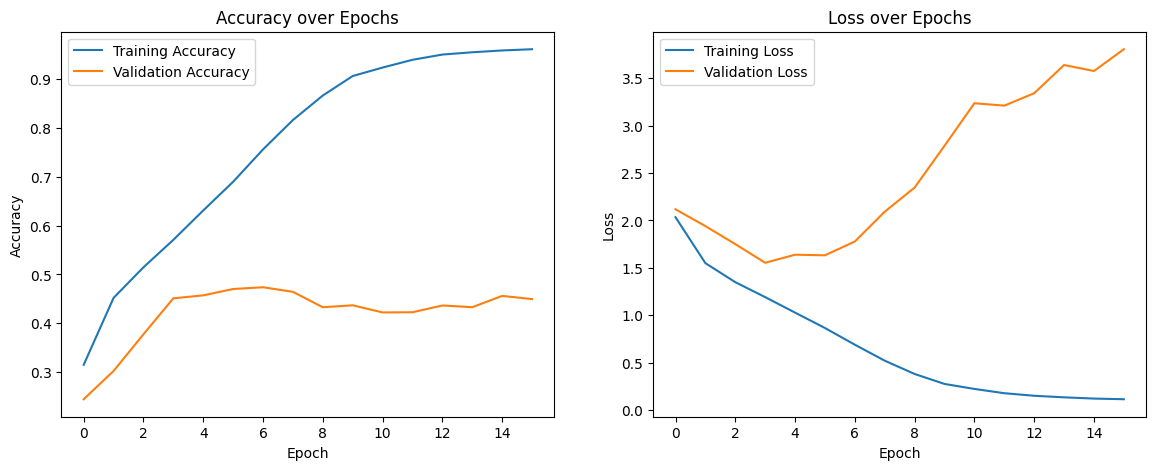

In [13]:
def plot_training_history(history):
    # График точности
    plt.figure(figsize=(14, 5))

    # Подграфик для точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Подграфик для потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history)